# Adding ARIMA to the equation!
### A function which combines AR with two new parameters - Integration, and Moving Average
* These parameters can be changed to get the best results out of the model
* Works better than AR, its more general.
* Still requires adherence to Auto-Regression assumptions 

$$
y_t = b + \sum_{j=1}^{P}w_{j}Y_{t-j} - \sum_{j=1}^{Q}x_{q}Z_{t-q} + \epsilon_t
$$

$$
where
$$

$$
AR = \sum_{j=1}^{P}w_{j}Y_{t-j}
$$

$$
MA = \sum_{q=1}^{Q}x_{q}Z_{t-q}
$$

$$
Integration = Y_{t-j} - Y_{t}
$$

$$
error = \epsilon_t
$$

$$
bias = b
$$


---

### Three parameters to ARIMA:
* p - autoregressive part (regression on the X data)
* d - integration (differencing)
* q - moving average part (of the residuals!!)

---

### We've actually seen the AR and the I part, lets look at a moving average example
* we can use the `rolling` function to achieve this

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
df = sns.load_dataset('flights')

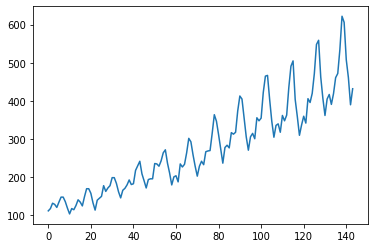

In [3]:
df.passengers.plot()

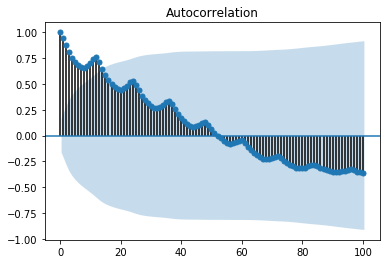

In [49]:
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(df.passengers, lags=100) # None, 100, 800

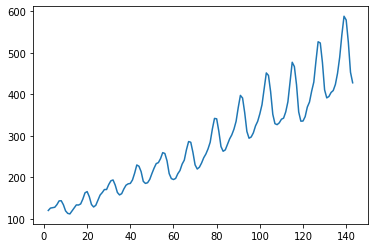

In [4]:
df.passengers.rolling(window=3).mean().plot()

### See, its a smoothed plot
* NB in actual ARIMA we are looking at the MA of the residuals, not the actual passengers data

### Right - lets stationarize our data in preparation to pass to ARIMA

In [5]:
df['datetime'] = df['year'].astype(str) + '-' + df['month'].astype(str)
df['datetime'] = pd.to_datetime(df['datetime'])

In [6]:
df['Date'] = pd.to_datetime(df.month.astype(str) + '-' + df.year.astype(str))
df.set_index('Date', inplace=True)
del df['datetime']

#### Variance

In [7]:
df['log_passengers'] = np.log(df.passengers)

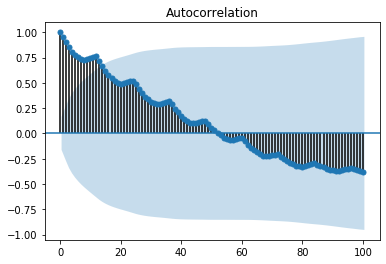

In [51]:
from statsmodels.graphics.tsaplots import plot_acf
acf = plot_acf(df.log_passengers, lags=100)

#### Trend

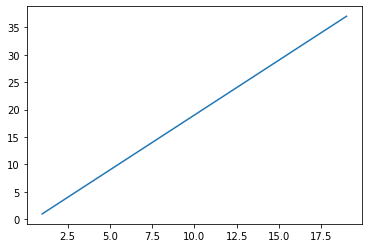

In [8]:
X = list(range(20))
y = [x**2 for x in X]
plt.plot(pd.Series(y).diff())

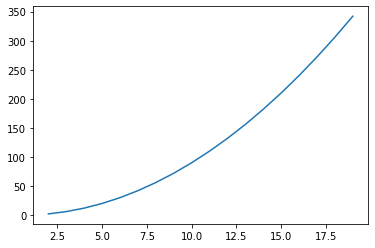

In [9]:
plt.plot(np.cumsum(np.cumsum(pd.Series(y).diff().diff())))

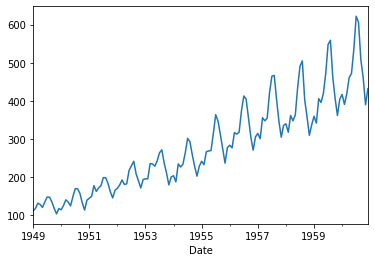

In [54]:
df.passengers.plot() #linear trend 


In [55]:
df['diff_log'] = df.log_passengers.diff()

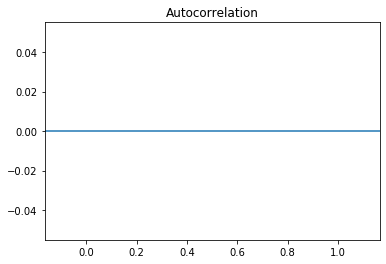

In [56]:
acf = plot_acf(df.diff_log, lags=100)

#### Seasonality

In [12]:
df['monthly_means'] = df.groupby('month')['diff_log'].transform('mean')
df['stationary_passengers'] = df.diff_log - df.monthly_means

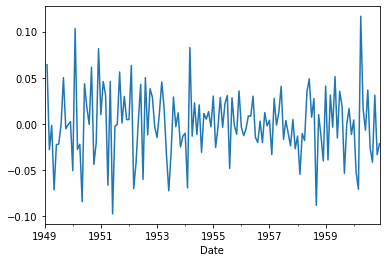

In [13]:
df.stationary_passengers.plot()

### OK - its stationarized

---

### Now lag the data

In [14]:
for i in range(1,13):
    df[f'{i}_shift_st_p'] = df.stationary_passengers.shift(i)
feature = ['12_shift_st_p']

### And fill NAs

In [15]:
df.fillna(method='bfill', inplace=True)

---

### Train-test split

In [16]:
train = df[:-20]['stationary_passengers']
test = df[-20:]['stationary_passengers']

## RECAP COMPLETE

---

### In order to preprocess yoru data for ARIMA, it needs to have variance removed, and seasonality removed!!!!

## Now Lets use ARIMA!

#### Parameters to ARIMA:
* The training data
* The order:
    * p - autoregressive part (regression on the X data, 0 to 3) - FIRST PARAMETER
    * d - integration (0 or 1) - SECOND PARAMETER
    * q - moving average part (of the residuals!!, 0 to 3) = THIRD PARAMETER

In [17]:
from statsmodels.tsa.arima_model import ARIMA

In [18]:
m = ARIMA(train, order=(1,1,1))

/Users/lara/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/Users/lara/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [19]:
m_fit = m.fit()

### Now its fit, we can use ARIMA to forecast future data
* We just need to define the # of time steps to be predicted
* It returns a tuple with the forecast, the standard error and the confidence intervals
* Lets just take the forecast

In [20]:
output = m_fit.forecast(steps=20)

In [21]:
output[0]

array([-0.00308607, -0.00329299, -0.00332107, -0.00338635, -0.0034439 ,
       -0.00350305, -0.00356187, -0.00362076, -0.00367963, -0.00373851,
       -0.00379738, -0.00385626, -0.00391514, -0.00397401, -0.00403289,
       -0.00409176, -0.00415064, -0.00420951, -0.00426839, -0.00432727])

In [22]:
ypred = output[0]

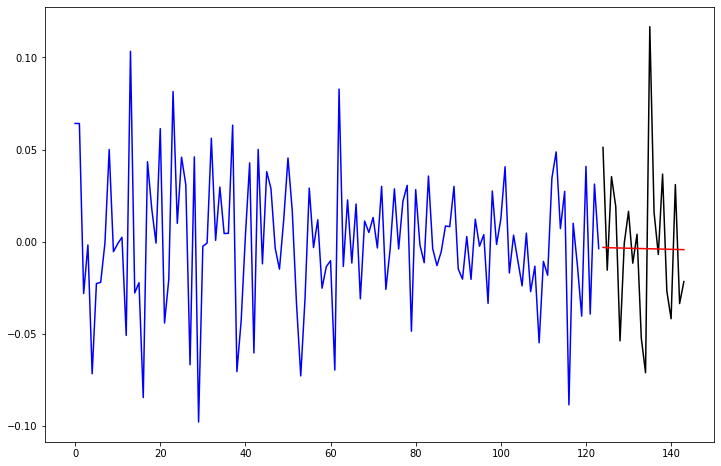

In [23]:
plt.figure(figsize=(12,8))
plt.plot(range(124), train, color='blue')
plt.plot(range(124, 144), test, color='black')
plt.plot(range(124,144), ypred, color='red')

### Interpret the results
* Is it a good result?
* Is the result in a format we want?

---

## Reconstruct
* To make our predictions useful, we need to reconstruct the data back into its original form
* Lets concatenate our ytest data with our new ypred on the column space
* We can use this recombined dataframe to reconstruct our ypred
* First we can reseason by adding back in the monthly means
* Second we can retrend:
    * a - Seed our prediction with the first value of the log passenger information
    * b - cumulatively sum this information into a new column 
* Third we can treat for variance by undoing our original log transform with an exponential transform

In [24]:
original = df[-20:]

In [25]:
#concat df[-20:] and ypred
prediction = pd.DataFrame(ypred, index=original.index, columns=['prediction'])

In [26]:
pred = pd.concat([prediction, original], axis=1)

In [27]:
pred.columns

Index(['prediction', 'year', 'month', 'passengers', 'log_passengers',
       'diff_log', 'monthly_means', 'stationary_passengers', '1_shift_st_p',
       '2_shift_st_p', '3_shift_st_p', '4_shift_st_p', '5_shift_st_p',
       '6_shift_st_p', '7_shift_st_p', '8_shift_st_p', '9_shift_st_p',
       '10_shift_st_p', '11_shift_st_p', '12_shift_st_p'],
      dtype='object')

In [28]:
#1: reseason our data
pred['reseasoned_pred'] = pred.prediction + pred.monthly_means

In [29]:
pred.head(1)

,prediction,year,month,passengers,log_passengers,diff_log,monthly_means,stationary_passengers,1_shift_st_p,2_shift_st_p,...,4_shift_st_p,5_shift_st_p,6_shift_st_p,7_shift_st_p,8_shift_st_p,9_shift_st_p,10_shift_st_p,11_shift_st_p,12_shift_st_p,reseasoned_pred
Date,,,,,,,,,,,,,,,,,,,,,
1959-05-01,-0.003086,1959,May,420,6.040255,0.058841,0.007696,0.051144,-0.003739,0.031246,...,0.040867,-0.040423,-0.013101,0.009997,-0.088578,0.02734,0.007087,0.048728,0.034504,0.00461


In [30]:
#2: retrend our data
pred.loc[pred.index[0],'reseasoned_pred'] = pred.loc[pred.index[0],'log_passengers']

In [31]:
pred.head(3)

,prediction,year,month,passengers,log_passengers,diff_log,monthly_means,stationary_passengers,1_shift_st_p,2_shift_st_p,...,4_shift_st_p,5_shift_st_p,6_shift_st_p,7_shift_st_p,8_shift_st_p,9_shift_st_p,10_shift_st_p,11_shift_st_p,12_shift_st_p,reseasoned_pred
Date,,,,,,,,,,,,,,,,,,,,,
1959-05-01,-0.003086,1959,May,420,6.040255,0.058841,0.007696,0.051144,-0.003739,0.031246,...,0.040867,-0.040423,-0.013101,0.009997,-0.088578,0.027340,0.007087,0.048728,0.034504,6.040255
1959-06-01,-0.003293,1959,June,472,6.156979,0.116724,0.132215,-0.015491,0.051144,-0.003739,...,-0.039307,0.040867,-0.040423,-0.013101,0.009997,-0.088578,0.027340,0.007087,0.048728,0.128922
1959-07-01,-0.003321,1959,July,548,6.306275,0.149296,0.114011,0.035285,-0.015491,0.051144,...,0.031246,-0.039307,0.040867,-0.040423,-0.013101,0.009997,-0.088578,0.027340,0.007087,0.110690


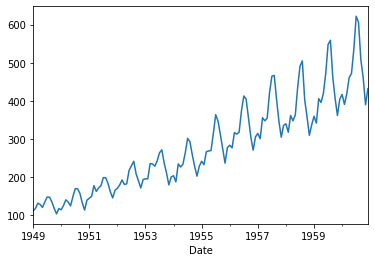

In [32]:
df.passengers.plot()

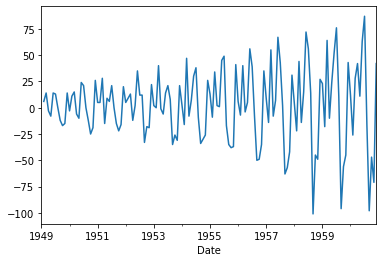

In [33]:
df.passengers.diff().plot()

In [34]:
# cumulatively sum our data - do cumsum twice for second order diffs
pred['retrended_data'] = np.cumsum(pred.reseasoned_pred)

In [35]:
pred.head(3)

,prediction,year,month,passengers,log_passengers,diff_log,monthly_means,stationary_passengers,1_shift_st_p,2_shift_st_p,...,5_shift_st_p,6_shift_st_p,7_shift_st_p,8_shift_st_p,9_shift_st_p,10_shift_st_p,11_shift_st_p,12_shift_st_p,reseasoned_pred,retrended_data
Date,,,,,,,,,,,,,,,,,,,,,
1959-05-01,-0.003086,1959,May,420,6.040255,0.058841,0.007696,0.051144,-0.003739,0.031246,...,-0.040423,-0.013101,0.009997,-0.088578,0.027340,0.007087,0.048728,0.034504,6.040255,6.040255
1959-06-01,-0.003293,1959,June,472,6.156979,0.116724,0.132215,-0.015491,0.051144,-0.003739,...,0.040867,-0.040423,-0.013101,0.009997,-0.088578,0.027340,0.007087,0.048728,0.128922,6.169177
1959-07-01,-0.003321,1959,July,548,6.306275,0.149296,0.114011,0.035285,-0.015491,0.051144,...,-0.039307,0.040867,-0.040423,-0.013101,0.009997,-0.088578,0.027340,0.007087,0.110690,6.279867


In [36]:
#erevariance our data - exponent of the log
pred['data'] = np.exp(pred.retrended_data)

In [37]:
pred.head(3)

,prediction,year,month,passengers,log_passengers,diff_log,monthly_means,stationary_passengers,1_shift_st_p,2_shift_st_p,...,6_shift_st_p,7_shift_st_p,8_shift_st_p,9_shift_st_p,10_shift_st_p,11_shift_st_p,12_shift_st_p,reseasoned_pred,retrended_data,data
Date,,,,,,,,,,,,,,,,,,,,,
1959-05-01,-0.003086,1959,May,420,6.040255,0.058841,0.007696,0.051144,-0.003739,0.031246,...,-0.013101,0.009997,-0.088578,0.027340,0.007087,0.048728,0.034504,6.040255,6.040255,420.000000
1959-06-01,-0.003293,1959,June,472,6.156979,0.116724,0.132215,-0.015491,0.051144,-0.003739,...,-0.040423,-0.013101,0.009997,-0.088578,0.027340,0.007087,0.048728,0.128922,6.169177,477.792588
1959-07-01,-0.003321,1959,July,548,6.306275,0.149296,0.114011,0.035285,-0.015491,0.051144,...,0.040867,-0.040423,-0.013101,0.009997,-0.088578,0.027340,0.007087,0.110690,6.279867,533.717558


In [38]:
# and plot

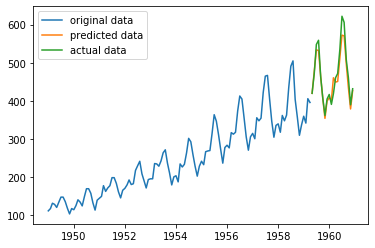

In [39]:
plt.plot(df.passengers[:-20])
plt.plot(pred.index,pred['data'])
plt.plot(pred.index, df.passengers[-20:])
plt.legend(['original data', 'predicted data' , 'actual data'])

---

### Finally - Check auto-correlation

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

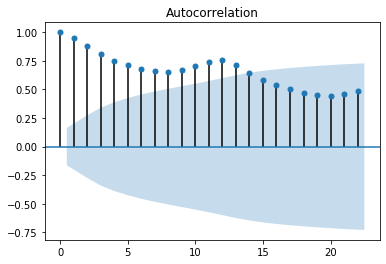

In [41]:
plot_acf(df.passengers)
None

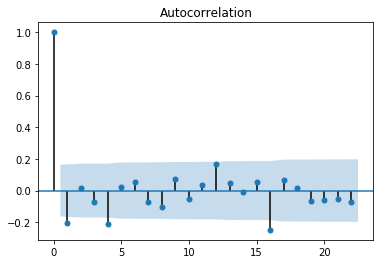

In [42]:
plot_acf(df.stationary_passengers) #take time lags outside the blue area with high correlation, for best results
None

ACF Plot Explained: https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/
- "Confidence intervals are drawn as a cone. By default, this is set to a 95% confidence interval, suggesting that correlation values **outside** of this code are very likely a correlation and **not** a statistical fluke."
- So basically, the AR model is taking the first 13 time lags because they are highly correlated with the prediction column (no. of passengers) and they are statistically significant.

---

---

### Further reading:
* Seasonal decomposition
* Statsmodels AR model
* Facebook Prophet
* non-manual - dickey-fuller, seasonal adjustment

#### Seasonal Decomposition

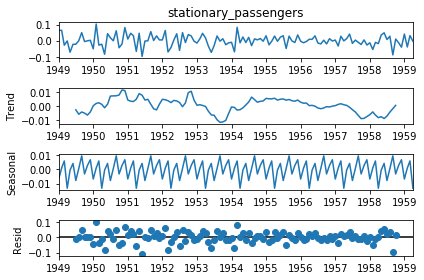

In [43]:
from statsmodels.tsa.seasonal import seasonal_decompose
sdc = seasonal_decompose(train, period=12, model='additive')
sdc.plot()
None

#### Statsmodel AR

/Users/lara/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarni

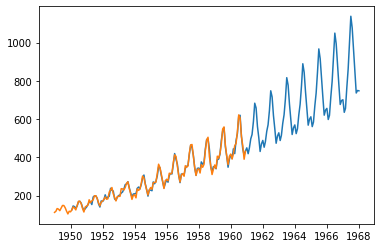

In [44]:
from statsmodels.tsa.ar_model import AR

ar = AR(df['passengers'])
ar_fitted = ar.fit()
ar_fitted.predict(end='1968')
ypred = ar_fitted.predict(end='1968')
plt.plot(ypred)
plt.plot(df['passengers'])

#### FB Prophet 

- https://facebook.github.io/prophet/docs/quick_start.html#python-api

#### Non-manual

- https://en.wikipedia.org/wiki/Seasonal_adjustment
- https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html